In [1]:
# Import libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("../input"))

['digit-recognizer']


Reference: 
1. [Convolutional Neural Network (CNN) Tutorial](https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial) by DATAI
2. [Introduction to CNN Keras - 0.997 (top 6%)](https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)
3. [Simple deep MLP with Keras](https://www.kaggle.com/code/fchollet/simple-deep-mlp-with-keras) by [fchollet](https://www.kaggle.com/fchollet)

In a later version of this Notebook we will have to make use of transfer learning and [Data augmentation](https://www.kaggle.com/code/ryanholbrook/data-augmentation/tutorial).

# Competition

In the [Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer) competition, the goal is to correctly identify digits from a dataset of tens of thousands of handwritten images (MNIST). Kaggle has curated a set of tutorial-style kernels which cover everything from regression to neural networks and encourages to experiment with different algorithms.

# Loading the Dataset

In [2]:
# Read the training data from csv-file
df_train = pd.read_csv("../input/digit-recognizer/train.csv")
print(df_train.shape)
df_train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Read the test data from csv-file
df_test = pd.read_csv("../input/digit-recognizer/test.csv")
print(df_test.shape)
df_test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Save the labels in the training data to a variable
Y_train = df_train["label"]

# Then drop the 'label' column from the training dataset
X_train = df_train.drop(labels = ["label"],axis = 1) 

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

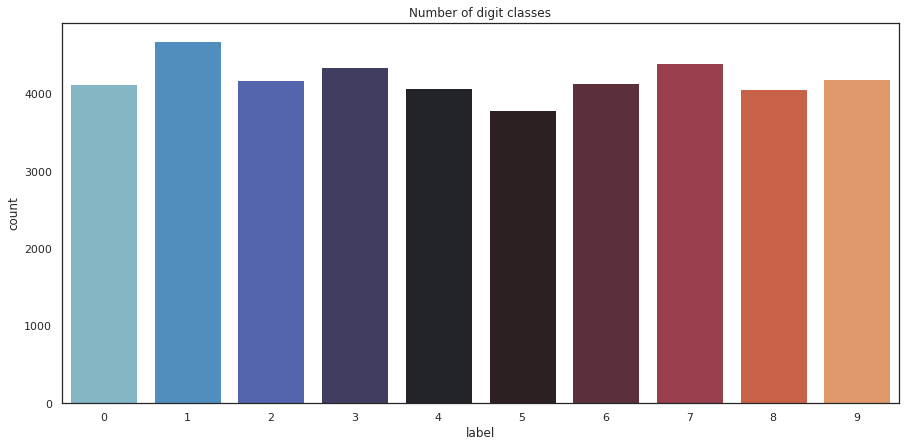

In [5]:
# Count and visualize the number of digits classes
plt.figure(figsize=(15,7))
g = sns.countplot(Y_train, palette="icefire")
plt.title("Number of digit classes")
Y_train.value_counts()

The counts for the digits are very similar.

In [6]:
# Check training data for null values
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
# Check test data for null values
df_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

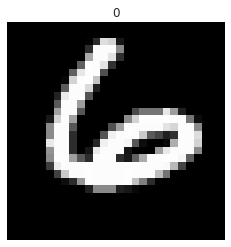

In [8]:
# Plot an example of the reshaped images
img = X_train.iloc[72].values
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(X_train.iloc[0,0])
plt.axis("off")
plt.show()

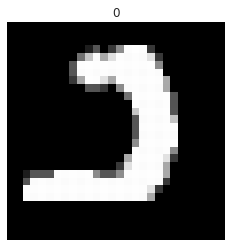

In [9]:
# Plot another example of the reshaped images
img = X_train.iloc[73].values
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(X_train.iloc[3,0])
plt.axis("off")
plt.show()

# Normalization, Reshape and Label Encoding

In [10]:
# Normalize the data, because CNNs work better with normalized data
X_train = X_train / 255.0
X_test = df_test / 255.0
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)

X_train shape:  (42000, 784)
X_test shape:  (28000, 784)


In [11]:
# Reshape all data to 28x28x1 3D matrices
X_train = X_train.values.reshape(-1,28,28,1) # Keras needs an extra dimension in the end (channels)
X_test = df_test.values.reshape(-1,28,28,1)
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)

X_train shape:  (42000, 28, 28, 1)
X_test shape:  (28000, 28, 28, 1)


In [12]:
# Label Encoding 
from keras.utils.np_utils import to_categorical 
Y_train = to_categorical(Y_train, num_classes = 10)
print(Y_train)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


# Train Test Split

In [13]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("X_val shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_val shape",Y_val.shape)

x_train shape (37800, 28, 28, 1)
X_val shape (4200, 28, 28, 1)
y_train shape (37800, 10)
y_val shape (4200, 10)


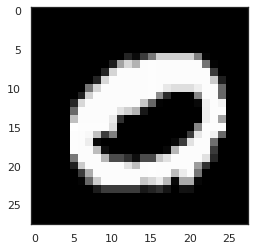

In [14]:
# Some examples
plt.imshow(X_train[21][:,:,0],cmap='gray')
plt.show()

# Convolutional Neural Network

Running convolutions and pooling for feature detection.

In [15]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

2022-08-16 19:03:05.709394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 19:03:05.823354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 19:03:05.824212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 19:03:05.825888: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), 
    loss = "categorical_crossentropy",
    metrics=["accuracy"]
)

In [17]:
epochs = 30 # Turn up to get more accuracy
batch_size = 86

# Data Augmentation

... to avoid or at least reduce overfitting.

In [18]:
# Data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=10,  # randomly rotate images in the range 10 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

# Train and evaluate the CNN

In [19]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [20]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

2022-08-16 19:03:09.170452: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-08-16 19:03:10.835658: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


439/439 - 17s - loss: 0.4047 - accuracy: 0.8705 - val_loss: 0.0699 - val_accuracy: 0.9798
Epoch 2/30
439/439 - 9s - loss: 0.1273 - accuracy: 0.9623 - val_loss: 0.0432 - val_accuracy: 0.9871
Epoch 3/30
439/439 - 10s - loss: 0.0931 - accuracy: 0.9723 - val_loss: 0.0299 - val_accuracy: 0.9917
Epoch 4/30
439/439 - 9s - loss: 0.0786 - accuracy: 0.9773 - val_loss: 0.0397 - val_accuracy: 0.9881
Epoch 5/30
439/439 - 9s - loss: 0.0715 - accuracy: 0.9790 - val_loss: 0.0310 - val_accuracy: 0.9912
Epoch 6/30
439/439 - 9s - loss: 0.0654 - accuracy: 0.9806 - val_loss: 0.0312 - val_accuracy: 0.9898
Epoch 7/30
439/439 - 9s - loss: 0.0649 - accuracy: 0.9814 - val_loss: 0.0239 - val_accuracy: 0.9924
Epoch 8/30
439/439 - 9s - loss: 0.0626 - accuracy: 0.9823 - val_loss: 0.0349 - val_accuracy: 0.9895
Epoch 9/30
439/439 - 9s - loss: 0.0594 - accuracy: 0.9827 - val_loss: 0.0265 - val_accuracy: 0.9938
Epoch 10/30
439/439 - 10s - loss: 0.0635 - accuracy: 0.9833 - val_loss: 0.0252 - val_accuracy: 0.9936
Epoch 1

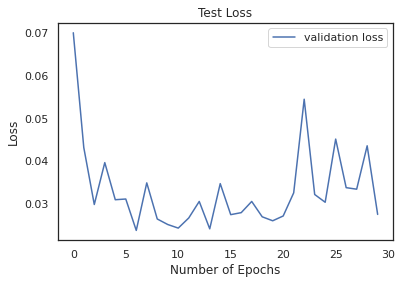

In [21]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Submission

In [22]:
# Submit to Kaggle Competition
results = model.predict(
    X_test,    
    verbose='auto',    
)

results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("submission.csv",index=False)